In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     "wa-sa-A2", "wa-sa-B4",
                                     "wa-sa-C4",
                                     "wa-sa-B3",  "wa-sa-B2",
                                     "wa-sa-A5", "wa-sa-A3",
                                     "wa-sa-C2",
                                     "wa-sa-C3", # Pos
                                     "wa-sa-D3", # Zero
                                     "wa-sa-D4", 
                                     "wa-sa-B1", "wa-sa-A4",
                                     "wa-sa-A1", "wa-sa-D2",
                                     "wa-sa-C5", # Pos
                                     "wa-sa-D5", # Zero
                                     "wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.6)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.ClusterHierarchyMeanClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     eps=0.21,
                                     contamination=0.004,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_wa)

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 5.782990647326944e-05, n_outlier: 22

Total error rate: 4.381306891269983e-05
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000016     0.000032   0.000202   0.000003   0.000011      0.0

Precision (TP / (TP + FP)): 0.9935861291232027
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.998181     0.997126   0.955569   0.999219   0.998571      1.0

Recall / TPR (TP / (TP + FN)): 0.9993619736282433
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0      0.99904   0.996086        1.0        1.0      1.0

Specificity / TNR (TN / (TN + FP)): 0.9999598821681969
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999984     0.999976   0.999813   0.999997   0.999989      1.0

Accuracy ((TP + TN) / (P + N)): 0.9999561869310873
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999984     0.999968   0.999798   0.999997   0.999989      1.0

Balanced Accuracy (S

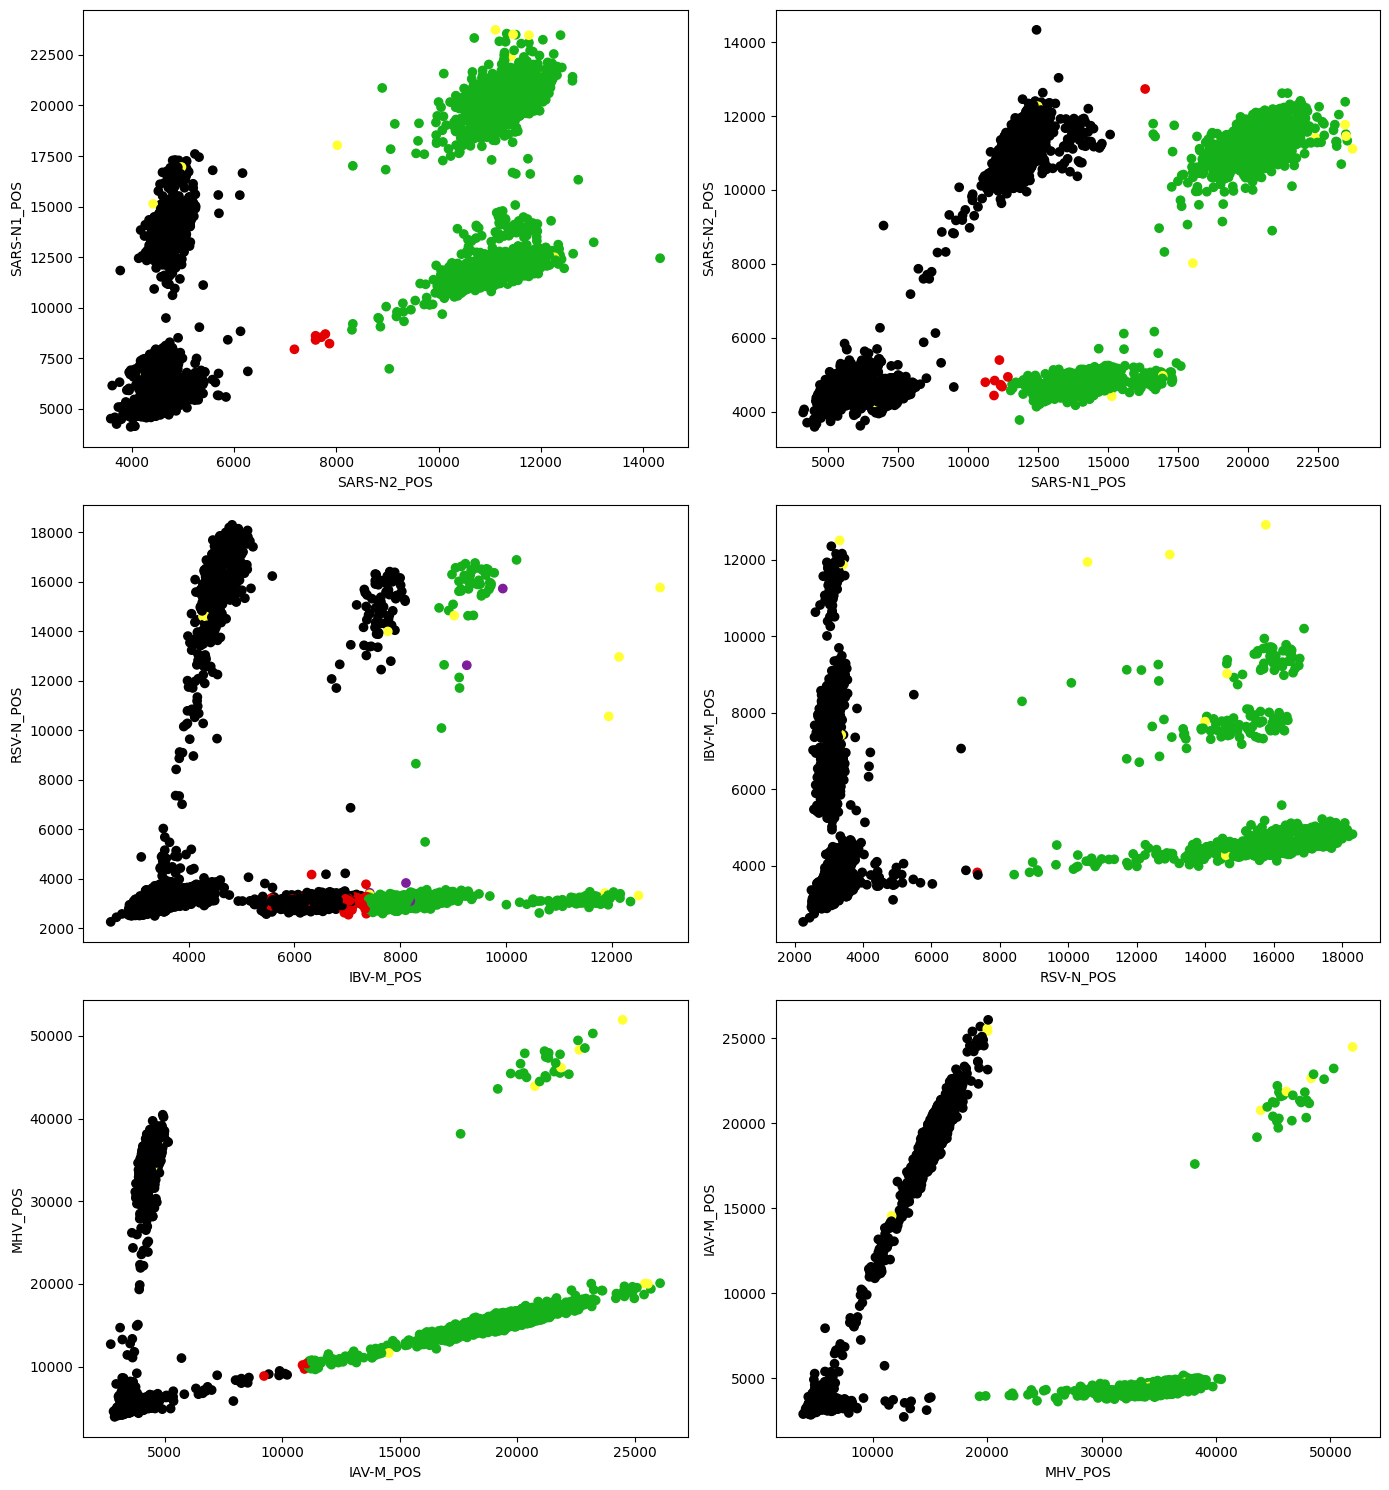

In [5]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions, decision.clusters_all >= 0)

plot_lib.plot_pairwise_selection(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.X_no_neg_mask
        )